# IDS 561 Homework 4 (Option 2)
Isaac Salvador<br>UIN: 669845132

## 1. Dataset
We first download the _Iris_ dataset and convert into a `spark` `rdd` object. Please note that the _Iris_ dataset was obtained from [kaggle](https://www.kaggle.com/datasets/uciml/iris/).

In [1]:
from pyspark.sql import SparkSession

# start spark session
sc = SparkSession.builder.appName("Homework4").getOrCreate()

file_path = "data/Iris.csv"
iris_df = sc.read.csv(file_path, header=True, inferSchema=True)

23/11/19 16:57:29 WARN Utils: Your hostname, Isaacs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.165 instead (on interface en0)
23/11/19 16:57:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/19 16:57:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


We then collapse the feature space as a `Vector` object for subsequent K-means analysis.

In [12]:
from pyspark.ml.linalg import Vectors

features = []

for i in iris_df.collect():
    features.append((i[0], Vectors.dense(i[1:5]), i[5]))

iris_features_df = sc.createDataFrame(features, ["id", "features", "Species"])

150

## 2. K-Means Model
We can then use the in-built `pyspark` module `Kmeans` to create a K-means model. We will naively use `K = 2` for the initial model.

In [18]:
from pyspark.ml.clustering import KMeans

# train k-means model
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(iris_features_df)

# make predictions
predictions = model.transform(iris_features_df)

# show predictions
predictions.show(5)

+---+-----------------+-----------+----------+
| id|         features|    Species|prediction|
+---+-----------------+-----------+----------+
|  1|[5.1,3.5,1.4,0.2]|Iris-setosa|         1|
|  2|[4.9,3.0,1.4,0.2]|Iris-setosa|         1|
|  3|[4.7,3.2,1.3,0.2]|Iris-setosa|         1|
|  4|[4.6,3.1,1.5,0.2]|Iris-setosa|         1|
|  5|[5.0,3.6,1.4,0.2]|Iris-setosa|         1|
+---+-----------------+-----------+----------+
only showing top 5 rows



## 3. Silhouette Score
Next we can evaluate the performance of this clustering.

In [19]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)

print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.8501515983265822


## 4. Improved Performance
To improve performance we will evaulate the silhouette score of ten iterations of increasing cluster size.

In [20]:
clusters = []
silhouettes = []

for i in range(3, 14):
    # instantiate model
    kmeans = KMeans().setK(i).setSeed(1)
    model = kmeans.fit(iris_features_df)
    predictions = model.transform(iris_features_df)
    
    # evaluate clusters
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    
    # log performance
    clusters.append(i)
    silhouettes.append(silhouette)

We can then plot Silhoutte Score vs. Clusters to visually inspect the perfomrance of the K-means model.

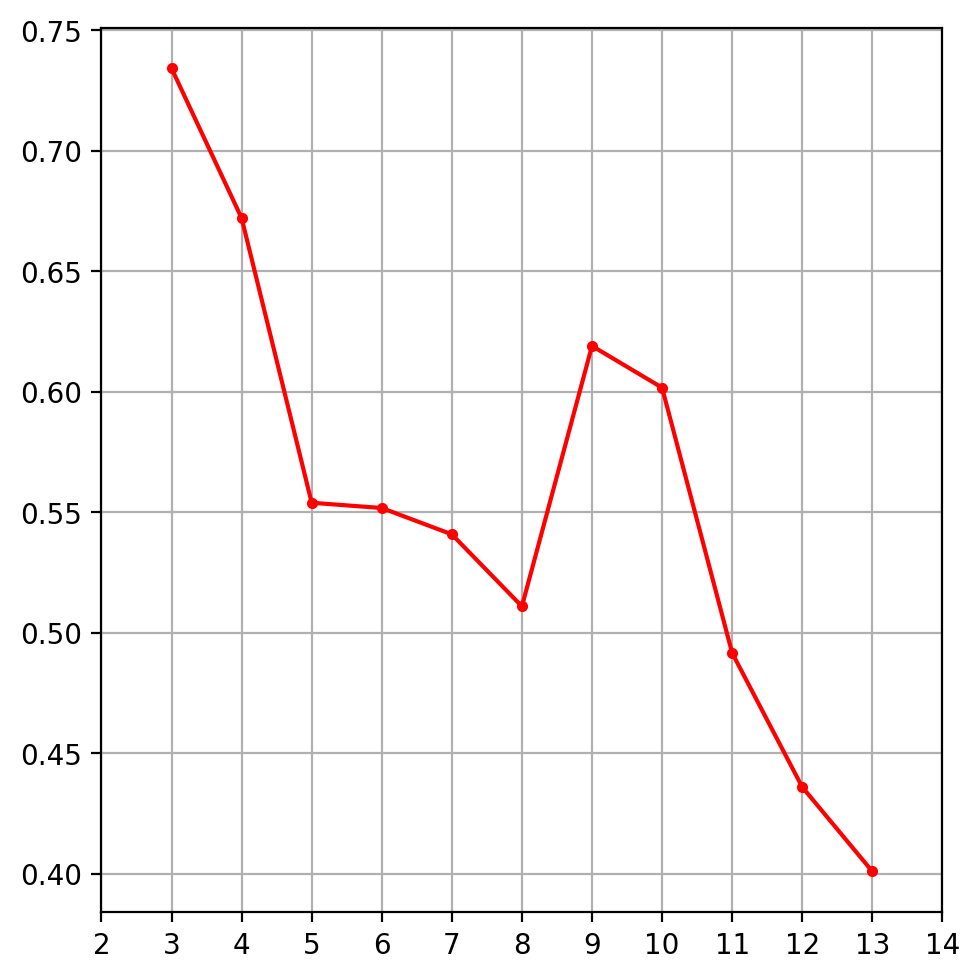

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=200)

plt.plot(clusters, silhouettes, "r.-")
plt.xticks(np.arange(2,15))

plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Best Clustering
While clustering at `K = 3` provides the best Silhouette Score, this value is trivial (As the original dataset provides 3 target values corresponding to the species of irises). A more nuanced clustering to select would be `K = 9` that, while providing a lower Silhouette Score, may provide greater insight on the data.

In [40]:
print(f"K = {clusters[6]} gives the best perfromance, Silhouette = {silhouettes[6]}")

K = 9 gives the best perfromance, Silhouette = 0.6189846047477922
